## Problem: Detection of aggressive tweets

Training dataset has 12776 tweets (in english) and validation dataset has 3194 tweets.<br/>
Tweets are labeled (by human) as:
* 1 (Cyber-Aggressive)
* 0 (Non Cyber-Aggressive)

# Baseline Model

### Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
data_train = pd.read_json('./Data/train.json')
data_train.head(3)

,content,label
0,i hate u like miniature dogs hate people dress...,1
1,you asian!!! I hate asians!!! Bahahahahhaha!!!...,1
2,austins new girllfriend is not uglly &amp;&a...,1


In [3]:
np.unique(data_train.label, return_counts=True)

(array([0, 1]), array([7706, 5070]))

In [4]:
data_valid = pd.read_json('./Data/valid.json')
data_valid.head(3)

,content,label
0,are you loyal?,0
1,Yvonne that's a french ass name Yvonne. My li...,1
2,WHUUT HAPPENEDD??,0


In [5]:
np.unique(data_valid.label, return_counts=True)

(array([0, 1]), array([1975, 1219]))

In [6]:
X_train = data_train.content
y_train = data_train.label
X_test = data_valid.content
y_test = data_valid.label

In [7]:
print('Training data: ', 'class 1 contribution = %.2f' % y_train.mean(), 
      '# = %s' % X_train.shape[0], sep='\n', end='\n\n')
print('Test data: ', 'class 1 contribution = %.2f' % y_test.mean(), 
      '# = %s' % X_test.shape[0], sep='\n')

Training data: 
class 1 contribution = 0.40
# = 12776

Test data: 
class 1 contribution = 0.38
# = 3194


### Preprocessing

In [8]:
from sklearn.base import TransformerMixin
import nltk
import string

In [9]:
class BasicTextPreprocessor(TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.punctuation_set = set(string.punctuation)
        self.stopwords_set = set(nltk.corpus.stopwords.words('english'))
        self.stemmer = nltk.PorterStemmer()
        return self
    
    def transform(self, X):        
        # convert to lowercase
        X_lower = [doc.lower() for doc in X]
        # split texts into words
        X_tokenized = [nltk.word_tokenize(doc) for doc in X_lower]
        # remove punctuation and stopwords
        X_cleaned = [[token for token in doc_tokenized 
                      if token not in self.punctuation_set and token not in self.stopwords_set]
                    for doc_tokenized in X_tokenized]        
        # leave stems of words
        X_stemmed = [[self.stemmer.stem(token) for token in doc_tokenized]
                    for doc_tokenized in X_cleaned]
        # join list of stems
        X_preprocessed = [' '.join(doc_tokenized) for doc_tokenized in X_stemmed]        
        return X_preprocessed

### Baseline model

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from myutils import *

In [11]:
pipe0 = Pipeline([('vectorizer', CountVectorizer()),
                  ('scaler', MaxAbsScaler()),
                  ('clf', LogisticRegression(penalty='l2', C=1.0))])

In [12]:
pipe0.fit(X_train, y_train);

In [13]:
y_train_pred = pipe0.predict(X_train)
y_test_pred = pipe0.predict(X_test)

In [14]:
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.927
Test dataset: accuracy = 0.817


In [15]:
pipe = Pipeline([('preprocessor', BasicTextPreprocessor()),
                 ('vectorizer', CountVectorizer()),
                 ('scaler', MaxAbsScaler()),
                 ('clf', LogisticRegression(penalty='l2', C=1.0))])

In [16]:
pipe.fit(X_train, y_train);

In [17]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

In [18]:
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.905
Test dataset: accuracy = 0.801


Accuracy seems to be a good metric because:
* distribution of classes is quite symmetric (1 - 40%, 0 - 60%),
* false positive (FP) and false negative (FN) have similar cost - we don't want to have too many FP and FN.

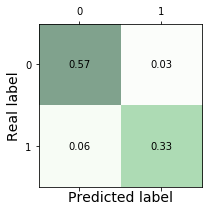

In [19]:
plot_confusion_matrix(y_train, y_train_pred)

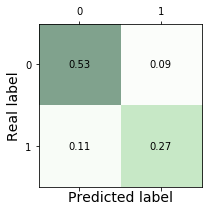

In [20]:
plot_confusion_matrix(y_test, y_test_pred)

There is similar rate of FP and FN so it seems that the threshold of 0.5 is correct.<br/>
We can check it using ROC as well.

In [21]:
from sklearn.metrics import roc_curve

In [22]:
y_test_proba = pipe.predict_proba(X_test)[:, 1]

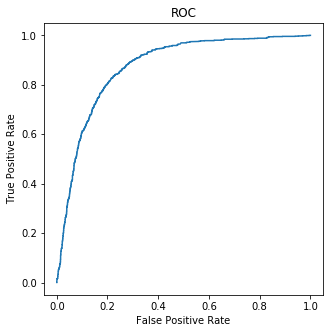

In [23]:
plot_roc_curve(y_labels=y_test, y_proba=y_test_proba)

In [24]:
fprs, tprs, thresholds = roc_curve(y_true=y_test, y_score=y_test_proba)

In [38]:
ind = np.argmax(tprs >= 0.74)

print('FPR: %.3f' % fprs[ind])
print('TPR: %.3f' % tprs[ind])
threshold = thresholds[ind]
print('Threshold: %.3f' % threshold)

FPR: 0.159
TPR: 0.742
Threshold: 0.487


In [39]:
y_test_pred_new_threshold = np.where(y_test_proba >= threshold, 1, 0)

In [40]:
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred_new_threshold, y_true=y_test))

Test dataset: accuracy = 0.803


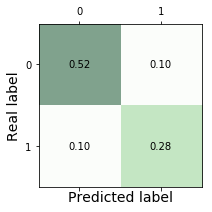

In [41]:
plot_confusion_matrix(y_test, y_test_pred_new_threshold)

Results suggest overfitting:

    Tarining dataset: accuracy = 0.905
    Test dataset: accuracy = 0.801

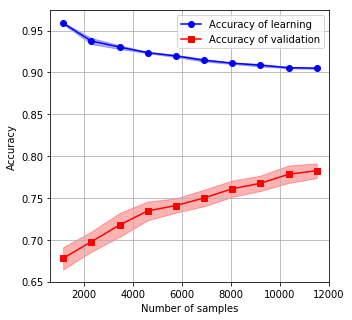

In [29]:
plot_learning_curve(estimator=pipe, X=X_train, y=y_train)